https://stepik.org/lesson/1576191/step/8

https://proproprogs.ru/nn_pytorch/pytorch-delaem-stilizaciyu-izobrazheniy-na-pytorch

(269, 179)

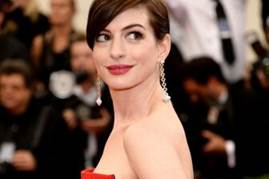

(269, 179)

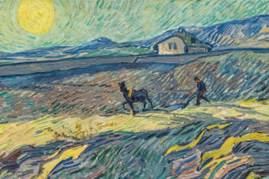

In [2]:
# @title Загрузка картинок на диск
import torch
import requests
from io import BytesIO
from PIL import Image

url_img = 'https://proproprogs.ru/htm/nn_pytorch/files/pytorch-delaem-stilizaciyu-izobrazheniy-na-pytorch.files/image001.jpg'
url_img_style = 'https://proproprogs.ru/htm/nn_pytorch/files/pytorch-delaem-stilizaciyu-izobrazheniy-na-pytorch.files/image002.jpg'

response = requests.get(url_img, stream=True)
img = Image.open(BytesIO(response.content)).convert('RGB')
img.save('img.jpg')

response = requests.get(url_img_style, stream=True)
img_style = Image.open(BytesIO(response.content)).convert('RGB')
img_style.save('img_style.jpg')

display(img.size, img, img_style.size, img_style)

Epoch 10/100, Loss: 82.8443
Epoch 20/100, Loss: 38.2333
Epoch 30/100, Loss: 25.5308
Epoch 40/100, Loss: 18.7563
Epoch 50/100, Loss: 14.9066
Epoch 60/100, Loss: 12.5632
Epoch 70/100, Loss: 11.0065
Epoch 80/100, Loss: 9.9061
Epoch 90/100, Loss: 9.0770
Epoch 100/100, Loss: 8.4255


144453

array([[[ 51,  38,  45],
        [ 46,  11,  33],
        [ 27,   0,  14],
        ...,
        [ 12,  15,   0],
        [  1,   9,   0],
        [  2,   4,   0]],

       [[ 23,  12,  13],
        [ 42,  15,  16],
        [ 68,  22,  17],
        ...,
        [ 13,  13,   1],
        [  3,  18,   0],
        [ 17,   1,   0]],

       [[ 53,  15,  16],
        [ 59,  14,   0],
        [ 26,  19,   0],
        ...,
        [ 13,  10,  16],
        [  6,  18,   9],
        [ 14,   9,   0]],

       ...,

       [[ 14,   0,   0],
        [ 49,   8,   5],
        [ 45,  43,   3],
        ...,
        [ 33,  59,  13],
        [ 30,  48,  20],
        [128,  89,  16]],

       [[ 42,  13,   1],
        [ 61,  36,   8],
        [ 46,  36,  17],
        ...,
        [ 67,  39,  13],
        [ 58,  38,   9],
        [103,  91,   6]],

       [[ 23,   0,   5],
        [ 63,  34,  17],
        [ 38,  39,  19],
        ...,
        [ 88,  10,   1],
        [107,  45,   0],
        [ 82,  83,   8]]], dtype=uint8)
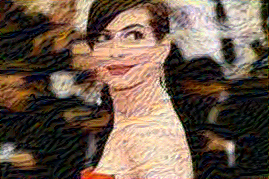

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim

# Определение модели для выделения признаков стиля и контента
class ModelStyle(nn.Module):
    def __init__(self):
        super().__init__()
        _model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.mf = _model.features
        self.mf.requires_grad_(False)
        self.requires_grad_(False)
        self.mf.eval()
        self.idx_out = (0, 5, 10, 19, 28, 34)  # Индексы слоев, используемых для стиля и контента
        self.num_style_layers = len(self.idx_out) - 1  # Количество слоев стиля, последний - для контента

    def forward(self, x):
        outputs = []
        for indx, layer in enumerate(self.mf):
            x = layer(x)
            if indx in self.idx_out:
                outputs.append(x.squeeze(0))

        return outputs

# Функция вычисления ошибки контента
def get_content_loss(base_content, target):
    return torch.mean(torch.square(base_content - target))

# Функция вычисления матрицы Грама для стиля
def gram_matrix(x):
    channels = x.size(dim=0)
    g = x.view(channels, -1)
    gram = torch.mm(g, g.mT) / g.size(dim=1)
    return gram

# Функция вычисления ошибки стиля
def get_style_loss(base_style, gram_target):
    style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]  # Веса для различных слоев стиля
    _loss = 0
    i = 0
    for base, target in zip(base_style, gram_target):
        gram_style = gram_matrix(base)
        _loss += style_weights[i] * torch.mean(torch.square(gram_style - target))
        i += 1

    return _loss

# Загрузка исходного изображения и изображения стиля
img = Image.open('img.jpg').convert('RGB')
img_style = Image.open('img_style.jpg').convert('RGB')

# Преобразования изображений для модели VGG19
transforms = tfs_v2.Compose([tfs_v2.ToImage(),
                             tfs_v2.ToDtype(torch.float32, scale=True)])

img = transforms(img).unsqueeze(0)
img_style = transforms(img_style).unsqueeze(0)
img_create = img.clone()
img_create.requires_grad_(True)

# Создание модели и получение признаков изображений
model = ModelStyle()
outputs_img = model(img)
outputs_img_style = model(img_style)

# Вычисление матриц Грама для стилевых признаков
gram_matrix_style = [gram_matrix(x) for x in outputs_img_style[:model.num_style_layers]]

# Гиперпараметры
content_weight = 1  # Важность контента
style_weight = 1000  # Важность стиля
best_loss = -1
epochs = 100

# Оптимизатор для обновления изображения
optimizer = optim.Adam(params=[img_create], lr=0.01)
best_img = img_create.clone()

# Основной цикл оптимизации
for _e in range(epochs):
    outputs_img_create = model(img_create)

    loss_content = get_content_loss(outputs_img_create[-1], outputs_img[-1])
    loss_style = get_style_loss(outputs_img_create, gram_matrix_style)
    loss = content_weight * loss_content + style_weight * loss_style

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    img_create.data.clamp_(0, 1)  # обрзаем значения пикселей

    # Сохранение лучшего результата
    if loss < best_loss or best_loss < 0:
        best_loss = loss
        best_img = img_create.clone()

    # Мониторинг обучения
    if (_e + 1) % 10 == 0 or _e == _e -1:
        print(f"Epoch {_e+1}/{epochs}, Loss: {loss.item():.4f}")

# Преобразование результата в изображение
x = best_img.detach().squeeze()
low, hi = torch.amin(x), torch.amax(x)
x = (x - low) / (hi - low) * 255.0
x = x.permute(1, 2, 0)
x = x.numpy()
x = np.clip(x, 0, 255).astype('uint8')

# Сохранение результата
# image = Image.fromarray(x, 'RGB') устарело, перестанет работать 2026-10-15
# актуальный вариант, Pillow сам определит режим изображения по типу и размеру массива x.
image = Image.fromarray(x)
image.save("result.jpg")

# Показываем результат
display(x.size, x)